# Do Protein Language Models Understand Evolution?  
# Exploring ESM2 Pseudo-perplexity of Maximum Likelihood Ancestral Protein Sequences

Protein language models like ESM2 are trained on huge datasets of natural protein sequences.  

Have they learned the evolutionary patterns underlying these sequences?

Can they assign reasonable plausibility to ancestrally reconstructed sequences that were not in the training set?

## ADA1 ASR as example

Try using human protein ADA1 as an example.

Performed ML ASR on ADA1.  Then calculated ESM2 pseudo perplexity of these ancestral sequences

## Visualize ADA1 tree

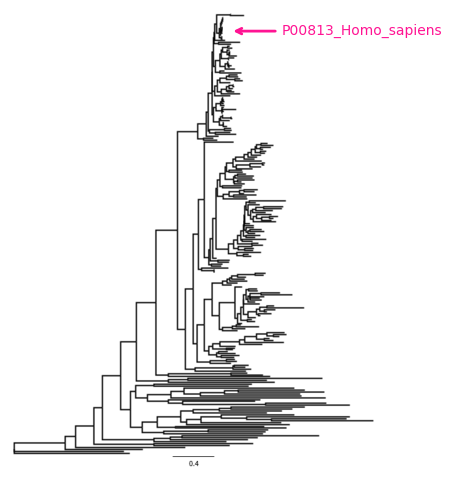

In [28]:
from data_processing import plot_image_with_arrows, plot_image_with_arrow_and_circles

img_path = 'images/ADA1_tree.png'
plot_image_with_arrows(
    img_path,
    x_starts=[0.73],
    x_ends=[0.60],
    arrow_ys=[0.045],
    labels=['P00813_Homo_sapiens'],
    text_offsets=[0.01]
)

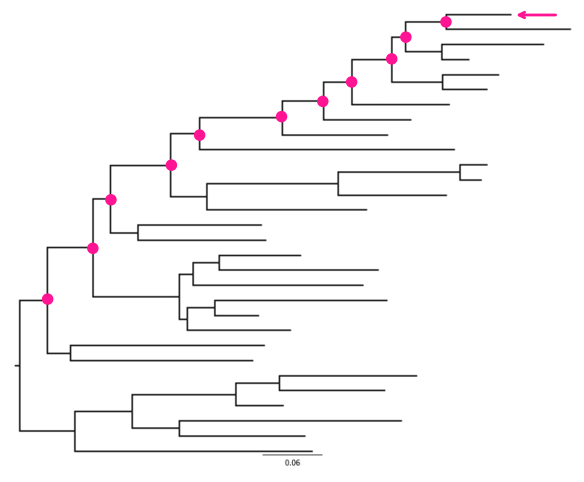

In [29]:
node_img_path = 'images/tree_nodes_example.png'
plot_image_with_arrow_and_circles(
    img_path=node_img_path,
    x_start=0.97,
    x_end=0.89,
    arrow_y=0.01,
    circle_positions=[(0.771, 0.025),(0.70,0.058),(0.675,0.105),(0.604,0.155),(0.553,0.197),
    (0.48,0.23),(0.335,0.27),(0.285,0.335),(0.178,0.41),(0.146,0.515),
    (0.066,0.625)],
    circle_radius=6
)

## Get calculated ESM2 pseudo-perplexity scores and ASR ML posterior probabilities

In [70]:
import pandas as pd
import json
import numpy as np

# Import ADA1 sequences scored for ESM2 pppl
#all_scores = pd.read_csv('ADA1_all_esm2_scores.csv')
all_scores = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/ADA1_all_650M_ids.csv')
all_scores = all_scores[['sequence_id', 'sequence', 'pseudo_perplexity']]

# Retrieve ML posterior probabilities from ASR run
ml_probs_json = 'ASR_notebook/ADA1_ASR/posterior_probabilities_no_gaps.json'

with open(ml_probs_json) as f:
    probs_dict = json.load(f)

all_scores['ML prob'] = all_scores['sequence_id'].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)

KeyError: "None of [Index(['sequence_id', 'sequence', 'pseudo_perplexity'], dtype='object')] are in the [columns]"

In [71]:
all_scores

,id
0,A0A833Z712_Phyllostomus_discolor
1,A0A2K6BYK1_Macaca_nemestrina
2,H0V758_Cavia_porcellus
3,A0A6P5P8G5_Mus_caroli
4,P03958_Mus_musculus
...,...
454,node456
455,node457
456,node458
457,node459


## Get phylogenetic tree with ancestral labels

In [31]:
from Bio import Phylo

tree_file = "ASR_notebook/ADA1_ASR/ancestor_tree.txt"
tree = Phylo.read(tree_file, "newick")

In [32]:
from data_processing import calc_branch_length_to_root_node, calc_branch_length_to_root_leaf

all_scores['bl_to_root'] = all_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))


## How does ESM2 pppl vary by age of ancestors from tree root to extant sequence?

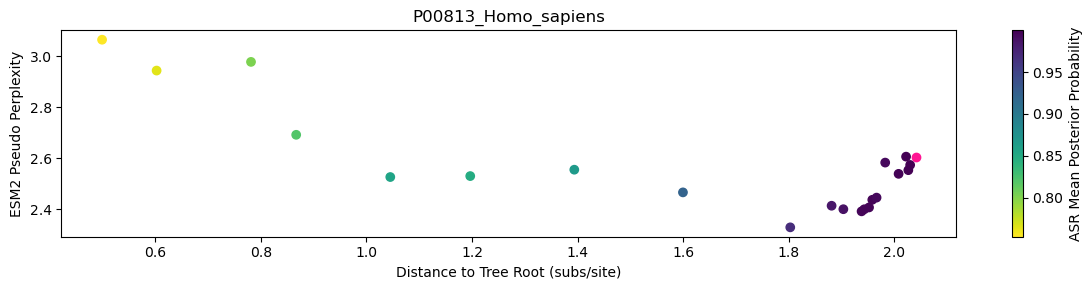

In [33]:
import matplotlib.pyplot as plt
from data_processing import get_node_labels_leaf_to_root
from data_processing import plot_evo_path

plot_evo_path(all_scores, tree, 'P00813_Homo_sapiens')

We observe a U-shaped pattern where more recent ancestral sequences have *lower* pppl scores than extant but then increases as ML support decreases with basal ancestors

## Look at other nodes in the tree

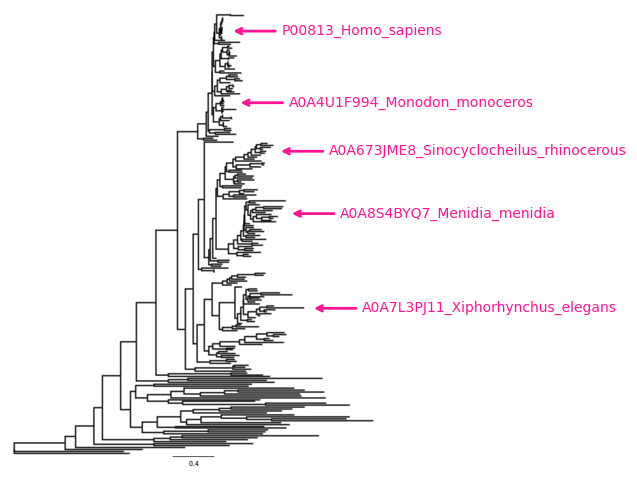

In [34]:
plot_image_with_arrows(
    img_path,
    x_starts=[0.73,0.75,0.89,0.86, 0.95],
    x_ends=[0.60,0.62,0.76,0.73, 0.82],
    arrow_ys=[0.045,0.2,0.44,0.305, 0.645],
    labels=['P00813_Homo_sapiens', 'A0A4U1F994_Monodon_monoceros', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A7L3PJ11_Xiphorhynchus_elegans'],
    text_offsets=[0.01, 0.01, 0.01, 0.01, 0.01]
)

## Do we see the same pattern for other extant sequences on the tree?

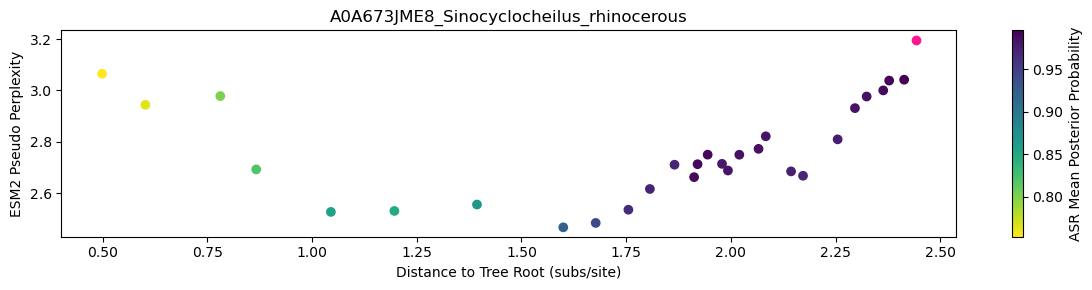

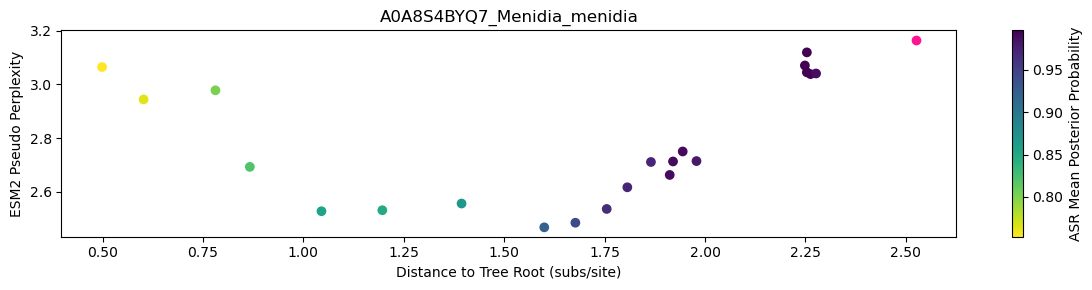

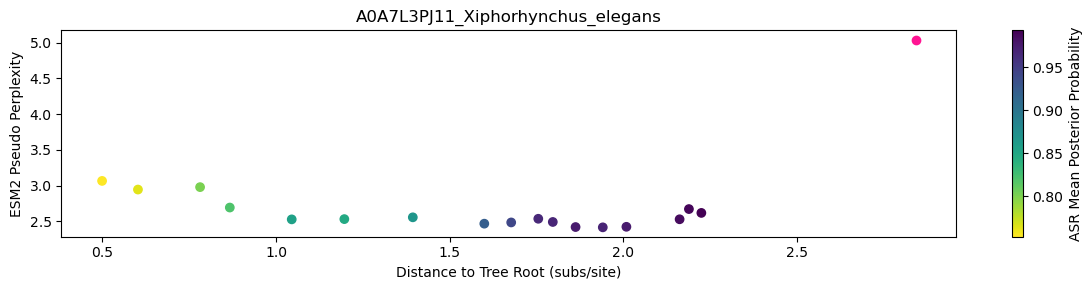

In [41]:
plot_evo_path(all_scores, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path(all_scores, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path(all_scores, tree, 'A0A7L3PJ11_Xiphorhynchus_elegans')

Generally see the same pattern for different native ADA1 sequences on the tree

## Is the decrease in pppl for recent ancestors driven by a consensus effect?

### Generate consensus sequences

In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from data_processing import generate_node_consensus, get_node_labels_leaf_to_root

leaves_of_interest = ['P00813_Homo_sapiens', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A7L3PJ11_Xiphorhynchus_elegans', 'A0A4U1F994_Monodon_monoceros'] 
ancestors_of_interest = []

for entry in leaves_of_interest:
    ancestors_of_interest.extend(get_node_labels_leaf_to_root(tree, entry))

ancestors_of_interest = list(set(ancestors_of_interest))

alignment_file = 'ASR_notebook/ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft.fa'
name_conv_dict = 'ASR_notebook/ADA1_ASR/recoding_dict.txt'
gap_dict_json = 'ASR_notebook/ADA1_ASR/gap_positions.json'

consensus_seq_file = 'consensus_ADA1_ancestors.fa'

records = []
for entry in ancestors_of_interest:
    consensus_seq = generate_node_consensus(tree, entry, alignment_file, name_conv_dict, gap_dict_json)
    name = entry + '_consensus'
    record = SeqRecord(Seq(consensus_seq), id=name, description="")
    records.append(record)

# Write all consensus sequences to a FASTA file
with open(consensus_seq_file, 'w') as file:
    SeqIO.write(records, file, "fasta")


found it


### Get Consensus ESM2 Pseudo Perplexity Scores

In [61]:
# retrieve esm2 scores for consensus seqs
consensus_file = 'consensus_ADA1_ancestors_esm2_scores.csv'
consensus_file = '/Users/isabel/Documents/ESM2/consensus_seqs.csv'
consensus_scores = pd.read_csv(consensus_file)
consensus_scores['orig_id'] = consensus_scores['sequence_id'].apply(lambda x: x.replace('_consensus', ''))
consensus_scores = consensus_scores[['orig_id', 'sequence', 'pseudo_perplexity']]
consensus_scores = consensus_scores.rename(columns={'sequence': 'consensus_seq', 'pseudo_perplexity': 'consensus_pppl', 'orig_id':'sequence_id'})


# add new consensus seqs and scores to scores df
all_scores = all_scores.merge(consensus_scores, how='left', on='sequence_id')

### Plotting

In [62]:
consensus_scores

,sequence_id,consensus_seq,consensus_pppl
0,node392,QVELHVHLDGAIRPETILHFGRKRGVPLPGSTVDDLLKHVSYKTPL...,2.687380
1,node233,MAENCSMSQTPTLLASFADKAAAFVSRRAALPKVELHVHLDGAIRP...,3.091120
2,node236,MAENSMSQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.486869
3,node243,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,2.422194
4,node242,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,2.404244
...,...,...,...
69,node340,MHIARRAAIGFGSPVLSSLTGRLSTMAELSSEQVVFNKPKVELHVH...,3.042355
70,node395,TRVFISRKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPA...,4.440962
71,node241,MQPGMAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADT...,2.494474
72,node238,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.475002


In [63]:
all_leaves = get_node_labels_leaf_to_root(tree, 'A0A8S4BYQ7_Menidia_menidia')

In [64]:
df_names = all_scores['sequence_id'].to_list()

[x for x in all_leaves if x not in df_names]

['node360',
 'node359',
 'node355',
 'node354',
 'node347',
 'node346',
 'node345',
 'node344']

In [65]:
'node354' in ancestors_of_interest

True

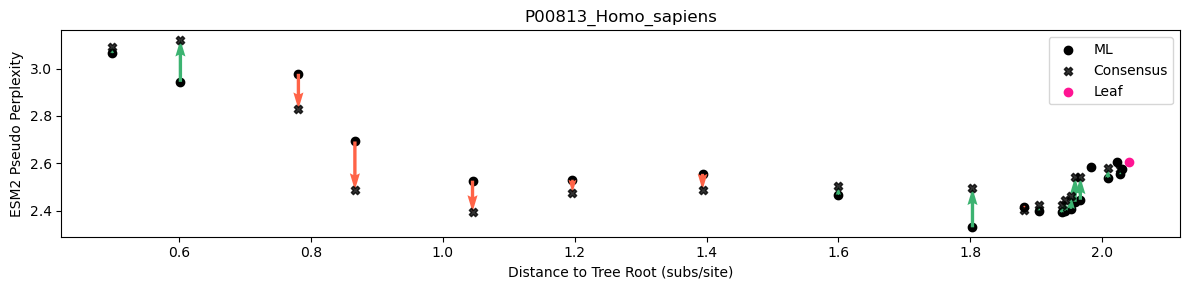

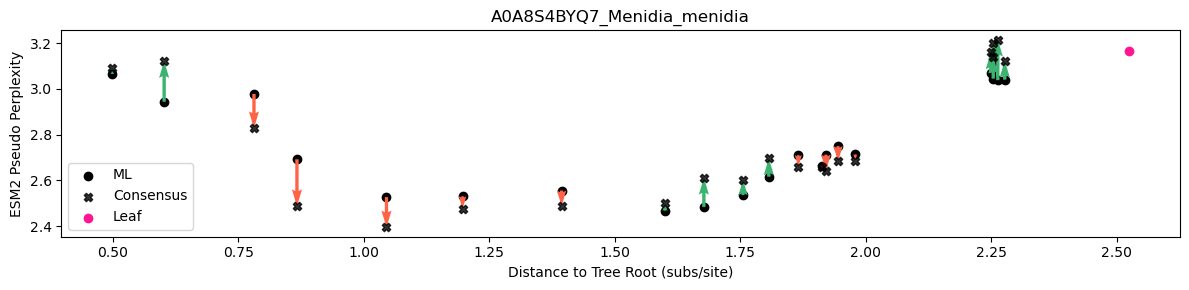

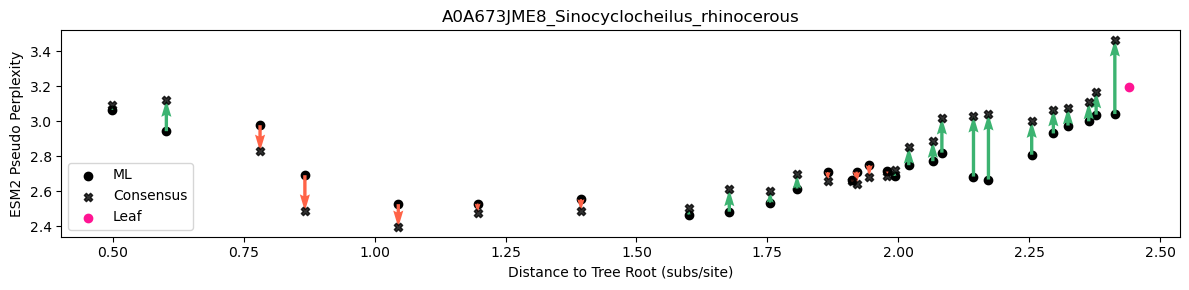

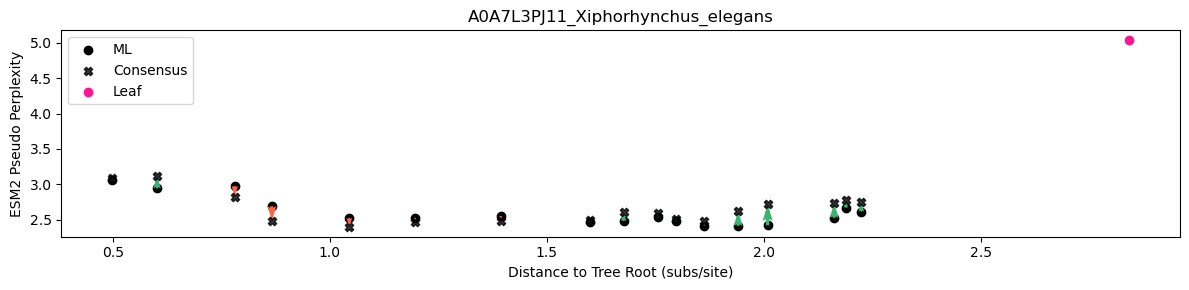

In [66]:
from data_processing import plot_evo_path_quiver

plot_evo_path_quiver(all_scores, tree, 'P00813_Homo_sapiens')
plot_evo_path_quiver(all_scores, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path_quiver(all_scores, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path_quiver(all_scores, tree, 'A0A7L3PJ11_Xiphorhynchus_elegans')



### Compare Consensus vs ML Ancestor Scores

Observe intriguing pattern where for more recent ancestors the pppl is *lower* for ML ancestors than consensus, but for older ancestors this flips.

Perhaps suggests ESM2 is actually learning some evolutionary signal and knows these low support ancestors are less plausible?

## Do smaller (or larger) models show similar behavior?

### Loading data

In [ ]:
# # writing fasta for esm2 scoring

# # which nodes do i really need
# all_nodes = []
# extant_list = ['P00813_Homo_sapiens','A0A4U1F994_Monodon_monoceros', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui', 'A0A7L3PJ11_Xiphorhynchus_elegans']
# for entry in extant_list:
#     all_nodes.extend(get_node_labels_leaf_to_root(tree, entry))

# all_nodes.extend(extant_list)

# len(list(set(all_nodes)))

# # limit to just these for esm2 scoring on huge models

# with open('subset_ADA1_seqs_for_esm2_scoring.fa', 'w') as file:
#     for index, row in all_scores.iterrows():
#         if row['sequence_id'] in all_nodes:
#             file.write(f">{row['sequence_id']}\n{row['sequence']}\n")

# # limit to just human for biggest model
# human_only = get_node_labels_leaf_to_root(tree, 'P00813_Homo_sapiens')
# human_only.append('P00813_Homo_sapiens')

# with open('human_ADA1_seqs_for_esm2_scoring.fa', 'w') as file:
#     for index, row in all_scores.iterrows():
#         if row['sequence_id'] in human_only:
#             file.write(f">{row['sequence_id']}\n{row['sequence']}\n")

# # already tested some, get remaining names
# already_tested = huge_model_scores['sequence_id'].to_list()
# remaining_only = [x for x in all_nodes if x not in already_tested]

# with open('remaining_ADA1_seqs_for_esm2_scoring.fa', 'w') as file:
#     for index, row in all_scores.iterrows():
#         if row['sequence_id'] in remaining_only:
#             file.write(f">{row['sequence_id']}\n{row['sequence']}\n")





In [ ]:
small_model_scores = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/all_ADA1_seqs_for_esm2_scoring_8M.csv')
med_model_scores = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/all_ADA1_seqs_for_esm2_scoring_35M.csv')
large_model_scores = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/all_ADA1_seqs_for_esm2_scoring_150M.csv')

df1 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_remaining_3B.csv')
df2 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_2more_3B.csv')
df3 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_just3_3B.csv')
df4 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/remaining_ADA1_3B.csv')
huge_model_scores = pd.concat([df1, df2, df3, df4])

small_model_scores['ML prob'] = small_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
small_model_scores['bl_to_root'] = small_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

med_model_scores['ML prob'] = med_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
med_model_scores['bl_to_root'] = med_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

large_model_scores['ML prob'] = large_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
large_model_scores['bl_to_root'] = large_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

huge_model_scores['ML prob'] = huge_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
huge_model_scores['bl_to_root'] = huge_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))




### Plotting functions

In [ ]:
import matplotlib.cm as cm

def plot_multiple_evo_lines(score_dfs_leaves_labels, tree, normalize=True):
    """
    Parameters:
        score_dfs_leaves_labels: list of tuples (scores_df, leaf_name, label_name)
        tree: Phylogenetic tree used to compute distances
        normalize: whether to normalize pseudo perplexity to the leaf value
    """
    plt.figure(figsize=(12, 3))
    
    n_lines = len(score_dfs_leaves_labels)
    colors = cm.rainbow_r(np.linspace(0, 1.0, n_lines))  # rainbow colormap

    for i, (scores_df, leaf_name, label_name) in enumerate(score_dfs_leaves_labels):
        color = colors[i]

        these_nodes = get_node_labels_leaf_to_root(tree, leaf_name)
        for_plot = scores_df[scores_df['sequence_id'].isin(these_nodes)].copy()
        for_plot.sort_values('bl_to_root', inplace=True)

        # Get leaf value
        leaf_value = scores_df[scores_df['sequence_id'] == leaf_name]['pseudo_perplexity'].to_list()[0]

        # Normalize if requested
        if normalize:
            for_plot['plot_value'] = for_plot['pseudo_perplexity'] / leaf_value
            y_leaf = 1.0
        else:
            for_plot['plot_value'] = for_plot['pseudo_perplexity']
            y_leaf = leaf_value

        x_leaf = calc_branch_length_to_root_leaf(tree, leaf_name)

        # Main line
        plt.plot(
            for_plot['bl_to_root'],
            for_plot['plot_value'],
            color=color,
            label=label_name
        )

        # Invisible marker at leaf
        plt.scatter(x_leaf, y_leaf, color=color, s=0.1, zorder=10)

        # Line to closest point
        closest_idx = (for_plot['bl_to_root'] - x_leaf).abs().idxmin()
        x_closest = for_plot.loc[closest_idx, 'bl_to_root']
        y_closest = for_plot.loc[closest_idx, 'plot_value']

        plt.plot(
            [x_leaf, x_closest],
            [y_leaf, y_closest],
            color=color
        )

    # Labels and layout
    plt.xlabel('Distance to Tree Root (subs/site)')
    y_label = 'Normalized Pseudo Perplexity\n(relative to leaf)' if normalize else 'Pseudo Perplexity'
    plt.ylabel(y_label)
    plt.title(leaf_name)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Results

In [ ]:
plot_multiple_evo_lines([(small_model_scores, 'P00813_Homo_sapiens', '8M'),(med_model_scores, 'P00813_Homo_sapiens', '35M'),(large_model_scores, 'P00813_Homo_sapiens', '150M'),(all_scores, 'P00813_Homo_sapiens', '650M'),(huge_model_scores, 'P00813_Homo_sapiens', '3B')], tree, normalize = False)
#plot_multiple_evo_lines([(small_model_scores, 'A0A4U1F994_Monodon_monoceros', '8M'),(med_model_scores, 'A0A4U1F994_Monodon_monoceros', '35M'),(large_model_scores, 'A0A4U1F994_Monodon_monoceros', '150M'),(all_scores, 'A0A4U1F994_Monodon_monoceros', '650M'),(huge_model_scores, 'A0A4U1F994_Monodon_monoceros', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '8M'),(med_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '35M'),(large_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '150M'),(all_scores, 'A0A8S4BYQ7_Menidia_menidia', '650M'),(huge_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '8M'),(med_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '35M'),(large_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '150M'),(all_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '650M'),(huge_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '3B')], tree, normalize = False)
#plot_multiple_evo_lines([(small_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '8M'),(med_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '35M'),(large_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '150M'),(all_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '650M'),(huge_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '3B')], tree, normalize = False)
#plot_multiple_evo_lines([(small_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '8M'),(med_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '35M'),(large_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '150M'),(all_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '650M'),(huge_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '3B')], tree, normalize = False)


Overall pppl values are lower for larger models, but the changes in relative pattern seem to differ.  Lets plot them normalized to the extant score.

### What if we normalize to extant leaf value?

In [ ]:
plot_multiple_evo_lines([(small_model_scores, 'P00813_Homo_sapiens', '8M'),(med_model_scores, 'P00813_Homo_sapiens', '35M'),(large_model_scores, 'P00813_Homo_sapiens', '150M'),(all_scores, 'P00813_Homo_sapiens', '650M'),(huge_model_scores, 'P00813_Homo_sapiens', '3B')], tree)
#plot_multiple_evo_lines([(small_model_scores, 'A0A4U1F994_Monodon_monoceros', '8M'),(med_model_scores, 'A0A4U1F994_Monodon_monoceros', '35M'),(large_model_scores, 'A0A4U1F994_Monodon_monoceros', '150M'),(all_scores, 'A0A4U1F994_Monodon_monoceros', '650M'),(huge_model_scores, 'A0A4U1F994_Monodon_monoceros', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '8M'),(med_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '35M'),(large_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '150M'),(all_scores, 'A0A8S4BYQ7_Menidia_menidia', '650M'),(huge_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '8M'),(med_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '35M'),(large_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '150M'),(all_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '650M'),(huge_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '3B')], tree)
#plot_multiple_evo_lines([(small_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '8M'),(med_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '35M'),(large_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '150M'),(all_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '650M'),(huge_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '8M'),(med_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '35M'),(large_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '150M'),(all_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '650M'),(huge_model_scores, 'A0A7L3PJ11_Xiphorhynchus_elegans', '3B')], tree)



## Does this generalize to ASR of other genes?  Try yeast isomaltase as different test case

### Get ESM2 scores for isomaltase ancestors

In [ ]:
# get ESM2 scores
iso_scores1 = pd.read_csv('/Users/isabel/Documents/ASR/isomaltase/060525_run/isomaltase_both_for_esm2_scoring_new_650M.csv')
iso_scores2 = pd.read_csv('/Users/isabel/Documents/ASR/isomaltase/060525_run/isomaltase_both_for_esm2_scoring_new_650M.csv')

iso_scores = pd.concat([iso_scores1, iso_scores2], ignore_index=True)

# retrieve the dictionary of probabilities from PAML output
ml_probs_json = '/Users/isabel/Documents/ASR/isomaltase/060525_run/posterior_probabilities_no_gaps.json'

with open(ml_probs_json, "r") as f:
    iso_probs_dict = json.load(f)

iso_scores['ML prob'] = iso_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)

tree_file = "/Users/isabel/Documents/ASR/isomaltase/060525_run/ancestor_tree.txt"
iso_tree = Phylo.read(tree_file, "newick")

iso_scores['bl_to_root'] = iso_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))


### Plot pppl vs branch length to root

In [ ]:
plot_evo_path(iso_scores, iso_tree, 'A0A420MWB1_Fusarium_oxysporum', labels=False)
plot_evo_path(iso_scores, iso_tree, 'A0A177DQL5_Alternaria_alternata', labels=False)
plot_evo_path(iso_scores, iso_tree, 'A0A4T0C5S8_Aureobasidium_pullulans', labels=False)
plot_evo_path(iso_scores, iso_tree, 'A0A1C1CJQ6_Cladophialophora_carrionii', labels=False)

### Isomaltase normalized by model size

#### Retrieve data for different models

In [ ]:
wd = '/Users/isabel/Documents/ASR/isomaltase/060525_run/'

iso_small_model_scores = pd.read_csv(wd + 'isomaltase_both_for_esm2_scoring_new_8M.csv')
iso_med_model_scores = pd.read_csv(wd + 'isomaltase_both_for_esm2_scoring_new_35M.csv')
iso_large_model_scores = pd.read_csv(wd + 'isomaltase_both_for_esm2_scoring_new_150M.csv')

df1 = pd.read_csv(wd + 'isomaltase_both_for_esm2_scoring_split1b.csv')
df2 = pd.read_csv(wd + 'isomaltase_both_for_esm2_scoring_split2.csv')
df3 = pd.read_csv(wd + 'isomaltase_both_for_esm2_scoring_split3.csv')
iso_huge_model_scores = pd.concat([df1, df2, df3])


iso_small_model_scores['ML prob'] = iso_small_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_small_model_scores['bl_to_root'] = iso_small_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_med_model_scores['ML prob'] = iso_med_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_med_model_scores['bl_to_root'] = iso_med_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_large_model_scores['ML prob'] = iso_large_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_large_model_scores['bl_to_root'] = iso_large_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_huge_model_scores['ML prob'] = iso_huge_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_huge_model_scores['bl_to_root'] = iso_huge_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))




#### Plot normalized pppl

In [ ]:
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '8M'),(iso_med_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '35M'),(iso_large_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '150M'),(iso_scores, 'A0A420MWB1_Fusarium_oxysporum', '650M'), (iso_huge_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '3B')], iso_tree, normalize = True)
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A177DQL5_Alternaria_alternata', '8M'),(iso_med_model_scores, 'A0A177DQL5_Alternaria_alternata', '35M'),(iso_large_model_scores, 'A0A177DQL5_Alternaria_alternata', '150M'),(iso_scores, 'A0A177DQL5_Alternaria_alternata', '650M'), (iso_huge_model_scores, 'A0A177DQL5_Alternaria_alternata', '3B')], iso_tree, normalize = True)
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '8M'),(iso_med_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '35M'),(iso_large_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '150M'),(iso_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '650M'), (iso_huge_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '3B')], iso_tree, normalize = True)
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A1C1CJQ6_Cladophialophora_carrionii', '8M'),(iso_med_model_scores, 'A0A1C1CJQ6_Cladophialophora_carrionii', '35M'),(iso_large_model_scores, 'A0A1C1CJQ6_Cladophialophora_carrionii', '150M'),(iso_scores, 'A0A1C1CJQ6_Cladophialophora_carrionii', '650M'), (iso_huge_model_scores, 'A0A1C1CJQ6_Cladophialophora_carrionii', '3B')], iso_tree, normalize = True)


In [ ]:
## Scatter plot of ML prob vs pppl


plt.scatter(iso_scores['ML prob'], iso_scores['pseudo_perplexity'])
plt.xlabel('bl_to_root')
plt.ylabel('pseudo_perplexity')
plt.title('Scatter Plot of column_x vs column_y')
plt.show()

In [ ]:
plt.scatter(all_scores['ML prob'], all_scores['pseudo_perplexity'])
plt.xlabel('bl_to_root')
plt.ylabel('pseudo_perplexity')
plt.title('Scatter Plot of column_x vs column_y')
plt.show()

In [ ]:
all_scores[all_scores['pseudo_perplexity'] > 5]

In [ ]:
plt.scatter(large_model_scores['ML prob'], large_model_scores['pseudo_perplexity'])
plt.xlabel('ML prob')
plt.ylabel('pseudo_perplexity')
plt.title('Scatter Plot of column_x vs column_y')
plt.grid(True)
plt.show()

In [ ]:
iso_scores

## Can visualizing the ESM2 embeddings help us understand the evolutionary relationships?

### Results for smaller model 

In [ ]:
model_to_plot = model_dfs[-1]

plot_evo_path_quiver(model_to_plot, tree, 'P00813_Homo_sapiens')
plot_evo_path_quiver(model_to_plot, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path_quiver(model_to_plot, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path_quiver(model_to_plot, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')
plot_evo_path_quiver(model_to_plot, tree, 'A0A7L3PJ11_Xiphorhynchus_elegans')


## ESMfold tell us anything about these ancestors?

In [ ]:
### Measure ADA1 ESMfold scores

# get all nodes
all_nodes = []
extant_list = ['P00813_Homo_sapiens','A0A4U1F994_Monodon_monoceros', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui', 'A0A7L3PJ11_Xiphorhynchus_elegans']
for entry in extant_list:
    all_nodes.extend(get_node_labels_leaf_to_root(tree, entry))

all_nodes.extend(extant_list)
all_nodes = list(set(all_nodes))

# first get ESMfold structures
esmfold_folder = '/Users/isabel/Documents/ASR/temp_asr_plm/esmfold/'
with open(esmfold_folder + 'ADA1_seqs_for_esmfold.fa', 'w') as file:
    for index, row in all_scores.iterrows():
        if row['sequence_id'] in all_nodes:
            file.write(f">{row['sequence_id']}\n{row['sequence']}\n")


In [ ]:
import os
def extract_ca_plddt(pdb_file):
    """Extract CA atom pLDDT scores from a PDB file."""
    plddt_dict = {}
    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith('ATOM') and line[12:16].strip() == 'CA':
                chain_id = line[21].strip()
                resnum = int(line[22:26].strip())
                b_factor = float(line[60:66].strip())
                plddt_dict[(chain_id, resnum)] = b_factor
    return plddt_dict

folded_anc = ['esmfold/predicted_structures/' + file for file in os.listdir('esmfold/predicted_structures/')]
esmfold_scores_dict = {}
low_esm_fold_scores_dict = {}
threshold = 0.6
for entry in folded_anc:
    esmfold_scores_dict[entry.split('/')[-1].split('.')[0]] = float(np.mean(list(extract_ca_plddt(entry).values())))
    low_esm_fold_scores_dict[entry.split('/')[-1].split('.')[0]] =  len([x for x in list(extract_ca_plddt(entry).values()) if x < threshold])/len(list(extract_ca_plddt(entry).values()))

In [ ]:
len([x for x in list(extract_ca_plddt(entry).values()) if x > 0.9])/len(list(extract_ca_plddt(entry).values()))

In [ ]:
all_scores['esmfold_plddt'] = all_scores['sequence_id'].apply(lambda x: esmfold_scores_dict[x] if x in esmfold_scores_dict else np.nan)
all_scores['esmfold_low_plddt'] = all_scores['sequence_id'].apply(lambda x: low_esm_fold_scores_dict[x] if x in low_esm_fold_scores_dict else np.nan)

In [ ]:
all_scores

In [ ]:
def plot_evo_path_esmfold(scores_df, tree, leaf_name, labels = False):
    these_nodes = get_node_labels_leaf_to_root(tree, leaf_name)

    # Subset the relevant data
    for_plot = scores_df[scores_df['sequence_id'].isin(these_nodes)]

    plt.figure(figsize=(12, 3))

    # Scatter plot with color representing ML probability
    scatter = plt.scatter(
        for_plot['bl_to_root'],
        for_plot['esmfold_low_plddt'],
        c=for_plot['ML prob'],
        cmap='viridis_r',
        marker='o'
    )

    #Add labels for each point using the sequence_id
    if labels == True: 
        for i, row in for_plot.iterrows():
            plt.text(
                row['bl_to_root'],
                row['esmfold_low_plddt'],
                row['sequence_id'],
                fontsize=9,
                ha='right',
                va='bottom'
            )


    # Add the leaf point in pink
    x = calc_branch_length_to_root_leaf(tree, leaf_name)
    y = scores_df[scores_df['sequence_id'] == leaf_name]['esmfold_low_plddt'].to_list()[0]
    plt.scatter(x, y, color='deeppink', label='Leaf', zorder=10)

    # Add colorbar
    plt.colorbar(scatter, label='ASR Mean Posterior Probability')

    # Labels and layout
    plt.xlabel('Distance to Tree Root (subs/site)')
    plt.ylabel('ESMfold plddt')
    plt.title(leaf_name)
    plt.tight_layout()
    plt.show()

plot_evo_path_esmfold(all_scores, tree, 'P00813_Homo_sapiens')

In [ ]:
# make histogram of plddt scores instead of just mean


# # Extract pLDDT values
# node233_plddt = list(extract_ca_plddt('esmfold/predicted_structures/node233.pdb').values())
# human_plddt = list(extract_ca_plddt('esmfold/predicted_structures/p00813-homo-sapiens.pdb').values())
# node245_plddt = list(extract_ca_plddt('esmfold/predicted_structures/node245.pdb').values())

# # Combine all data to compute shared bins
# all_plddt = node233_plddt + human_plddt + node245_plddt
# min_val, max_val = min(all_plddt), max(all_plddt)
# bins = np.linspace(min_val, max_val, 21)  # 10 equal-width bins

# # Plot histograms with shared bins
# plt.hist(node233_plddt, bins=bins, alpha=0.6, label='node233')
# plt.hist(human_plddt, bins=bins, alpha=0.6, label='human')
# plt.hist(node245_plddt, bins=bins, alpha=0.6, label='node245')

# plt.ylabel('esmfold pLDDT count')
# plt.xlabel('pLDDT')
# plt.legend()
# plt.show()


# print (len([x for x in node233_plddt if x < 0.5]))
# print (len([x for x in node245_plddt if x < 0.5]))
# print (len([x for x in human_plddt if x < 0.5]))



In [ ]:
# plot plddt across protein

plt.figure(figsize=(12, 4))
plt.plot(node233_plddt, label='Node233')
plt.plot(human_plddt, label='Human')
plt.plot(node245_plddt, label='Node245')
plt.xlabel('Residue Position')
plt.ylabel('pLDDT')
plt.title('Residue-level Confidence from ESMFold')
plt.legend()
plt.tight_layout()
plt.show()


## Thornton epistasis paper provide any ground truth?


In [ ]:
thornton_esm = '/Users/isabel/Documents/Evolvability/thornton_data/thornton_anc.csv'
more_thornton = '/Users/isabel/Documents/Evolvability/thornton_data/thornton_more.csv'

thornton_df1 = pd.read_csv(thornton_esm)
thornton_df2 = pd.read_csv(more_thornton)

thornton_df = pd.concat([thornton_df1, thornton_df2], ignore_index=True)

# mapping nodes to names
node_mapping = {'AncSR1': '399', 'AncSR':'376', 'AncNR3':'332', 'AncSco':'392', 'AncPro':'379', 'AncSed':'391', 'AncAnn':'387', 'HumanGR': 'H_sapiens_GR', 'CteletaSR': 'C_teleta_ER'}

thornton_df['real_name'] = thornton_df['sequence_id'].apply(lambda x: 'node' + node_mapping[x] if 'Anc' in x else node_mapping[x] if 'node' not in x else x)
thornton_df = thornton_df[['real_name', 'pseudo_perplexity', 'sequence']]

# rename columns
thornton_df = thornton_df.rename(columns={'real_name': 'sequence_id'})
thornton_df


In [ ]:
# add branch lengths into table
orig_rooted_tree = '/Users/isabel/Documents/Evolvability/thornton_data/my_parsed_paml_outputs/ancestor_tree.txt'
thornton_tree = Phylo.read(orig_rooted_tree, 'newick')

thornton_df['bl_to_root'] = thornton_df['sequence_id'].apply(lambda x: 0 if x == 'node222' else calc_branch_length_to_root_node(thornton_tree, x[4:]) if 'node' in x else calc_branch_length_to_root_leaf(thornton_tree, x))

thornton_df


In [ ]:
# add ML probs
ml_probs_json = '/Users/isabel/Documents/Evolvability/thornton_data/my_parsed_paml_outputs/posterior_probabilities.json'

with open(ml_probs_json, "r") as f:
    probs_dict = json.load(f)

thornton_df['ML prob'] = thornton_df['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)

In [ ]:
plot_evo_path(thornton_df, thornton_tree, 'H_sapiens_GR', labels = True)
plot_evo_path(thornton_df, thornton_tree, 'C_teleta_ER', labels = True)

In [ ]:
# Compare to consensus sequences

alignment_file = ''

name_conv_dict = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/recoding_dict.txt'
gap_dict_json = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/gap_positions.json'

consensus_seq_file = '/Users/isabel/Documents/ESM2/consensus_seqs.fa'

with open(consensus_seq_file, 'w') as file:
    for entry in ancestors_of_interest:
        consensus_seq = generate_node_consensus(tree, entry, alignment_file, name_conv_dict, gap_dict_json)
        name = entry + '_consensus'
        file.write('>' + name + '\n' + consensus_seq + '\n')



In [ ]:
# look at thornton fitness data

thornton_fitness_df = pd.read_csv('/Users/isabel/Documents/Evolvability/thornton_data/Supplementary files/dF.txt', sep = ' ')

# add in name of wt
mapping_df = pd.read_csv('/Users/isabel/Documents/Evolvability/thornton_data/Supplementary files/Notes.txt', sep = ':')
# rename 1st column
mapping_df.rename(columns = {mapping_df.columns[0]: 'anc_number'}, inplace = True)
mapping_df.rename(columns = {mapping_df.columns[1]: 'anc_name'}, inplace = True)
mapping_dict = mapping_df.set_index('anc_number')['anc_name'].to_dict()

# add new column that maps name from mapping_df to df
thornton_fitness_df['anc_name'] = thornton_fitness_df['PROT'].apply(lambda x: mapping_dict[str(x)])
thornton_fitness_df['anc_name'] = thornton_fitness_df['anc_name'].str.replace(' ', '')

# get rid of log10 and average
thornton_fitness_df['F1_actual'] = thornton_fitness_df['F1'].apply(lambda x: 10**float(x))
thornton_fitness_df['F2_actual'] = thornton_fitness_df['F2'].apply(lambda x: 10**float(x))
thornton_fitness_df['F3_actual'] = thornton_fitness_df['F3'].apply(lambda x: 10**float(x))
thornton_fitness_df['ave_F_actual'] = thornton_fitness_df[['F1_actual', 'F2_actual', 'F3_actual']].mean(axis=1)


#Identify wild-type rows
wt = thornton_fitness_df[thornton_fitness_df['WTAA'] == thornton_fitness_df['MTAA']].copy()
wt = wt[['anc_name', 'ave_F_actual']].rename(columns={'avg_fitness': 'WT_F_avg'})
wt = wt[~wt['anc_name'].str.contains('Alt')]

# average wt
wt = thornton_fitness_df[thornton_fitness_df['WTAA'] == thornton_fitness_df['MTAA']].copy()
result = wt.groupby('anc_name', as_index=False)['ave_F_actual'].mean()
result = result.rename(columns={'avg_fitness': 'ave_ave_fitness'})


result

In [ ]:


order_ctel = ['C.teletaSR', 'ScolecidSR', 'SedentarianSR', 'AnnelidSR', 'ProtostomeSR', 'AncSR', 'AncNR3']
order_human = ['HumanGR', 'AncSR1', 'AncSR', 'AncNR3']


for entry in order_human:
    print (entry, ':', result[result['anc_name'] == entry]['ave_F_actual'].to_list()[0])
    



In [ ]:
len(all_nodes)

In [ ]:
plt.hist(thornton_fitness_df['ave_F_actual'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Average Fitness')
plt.ylabel('Count')
plt.title('Histogram of avg_fitness')
plt.show()

## Thioredoxin dataset as ground truth?

In [ ]:
# load in perplexity scores

trx_8M = pd.read_csv('TRX_ASR_paper/Trx_8M.csv')
trx_8M = trx_8M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_8M'})

trx_35M = pd.read_csv('TRX_ASR_paper/Trx_35M.csv')
trx_35M = trx_35M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_35M'})

trx_150M = pd.read_csv('TRX_ASR_paper/Trx_150M.csv')
trx_150M = trx_150M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_150M'})

trx_650M = pd.read_csv('TRX_ASR_paper/Trx_650M.csv')
trx_650M = trx_650M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_650M'})

trx_3B = pd.read_csv('TRX_ASR_paper/Trx_3B.csv')
trx_3B = trx_3B[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_3B'})

# Merge all on sequence_id
trx_df = trx_8M.merge(trx_35M, on='sequence_id') \
               .merge(trx_150M, on='sequence_id') \
               .merge(trx_650M, on='sequence_id') \
               .merge(trx_3B, on='sequence_id')

# add in age and fitness scores
trx_fitness_df = pd.read_csv('TRX_ASR_paper/Trx_fitness.csv')
trx_fitness_df

trx_df = trx_df.merge(trx_fitness_df, on='sequence_id')

trx_df['sequence_id'] = trx_df['sequence_id'].apply(lambda x: x.replace(' ', ''))
trx_df


In [ ]:
plt.figure(figsize=(10, 6))
plot_list = ['LBCA_Trx', 'LPBCA_Trx', 'LGPCA_Trx', 'E_coli_Trx']
#plot_list =['AECA_Trx', 'LECA_Trx', 'LAFCA_Trx', 'Human_Trx']
plot_df = trx_df[trx_df['sequence_id'].isin(plot_list)].copy()

# Normalize pppl values (min-max) for each model size
pppl_cols = ['pppl_8M', 'pppl_35M', 'pppl_150M', 'pppl_650M', 'pppl_3B']
for col in pppl_cols:
    min_val = trx_df[col].min()
    max_val = trx_df[col].max()
    plot_df[col] = (plot_df[col] - min_val) / (max_val - min_val)

# Plot normalized values
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Age'], plot_df['pppl_8M'],     label='8M')
plt.scatter(plot_df['Age'], plot_df['pppl_35M'],    label='35M')
plt.scatter(plot_df['Age'], plot_df['pppl_150M'],   label='150M')
plt.scatter(plot_df['Age'], plot_df['pppl_650M'],   label='650M')
plt.scatter(plot_df['Age'], plot_df['pppl_3B'],     label='3B')

plt.xlabel('Age (Gyr)')
plt.ylabel('Normalized Pseudo-Perplexity')
plt.title('Normalized Pseudo-Perplexity vs Age for Different Model Sizes')
plt.legend(title='Model Size')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
trx_df

In [ ]:
plt.scatter(plot_df['Age'], plot_df['Tm'])

In [ ]:
plot_df

In [ ]:
get_node_labels_leaf_to_root(tree, 'P00813_Homo_sapiens')

In [ ]:
all_scores.to_csv('/Users/isabel/Documents/ASR/temp_asr_plm/ADA1_all_scores.csv')

In [ ]:
all_scores

In [ ]:
# create matching esm2 scores for consensus seqs

output_file = 'consensus_ADA1_ancestors_esm2_scores.csv'
full_consensus_df = pd.read_csv('/Users/isabel/Documents/ESM2/consensus_seqs.csv')
flag = []
with open(output_file, 'w') as file:
    for index, row in full_consensus_df.iterrows():
        if row['sequence_id'] in consensus_of_interest:
            flag.append(1)
        else:
            flag.append(0)

full_consensus_df['include'] = flag
include_df = full_consensus_df[full_consensus_df['include'] == 1]
include_df.drop(columns=['include'], inplace=True)
include_df.to_csv(output_file, index = False)